# GradCAM in X-ray images
### by Phuong T.M. CHU

In [25]:
import os
import numpy as np
import cv2
from matplotlib import pyplot as plt
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.densenet import preprocess_input, decode_predictions

import tensorflow as tf
from tensorflow.python.framework import ops

ops.disable_eager_execution()

## Define model here

In [ ]:
from tensorflow.keras.models import load_model

model = load_model('model_3ep.h5')
model.summary()

In [26]:
def build_model():
    """Function returning keras model instance.
    
    Model can be
     - Trained here
     - Loaded with load_model
     - Loaded from keras.applications
    """
    return model

H, W = 224, 224 # Input shape, defined by the model (model.input_shape)

### Utility functions

In [27]:
def load_image(path, preprocess=True):
    """Load and preprocess image."""
    x = image.load_img(path, target_size=(H, W))
    if preprocess:
        x = image.img_to_array(x)
        x /= 255
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
    return x

def normalize(x):
    """Utility function to normalize a tensor by its L2 norm"""
    return (x + 1e-10) / (K.sqrt(K.mean(K.square(x))) + 1e-10)

### Guided Backprop

In [28]:
def build_guided_model():
    """Function returning modified model.
    
    Changes gradient function for all ReLu activations
    according to Guided Backpropagation.
    """
    if "GuidedBackProp" not in ops._gradient_registry._registry:
        @ops.RegisterGradient("GuidedBackProp")
        def _GuidedBackProp(op, grad):
            dtype = op.inputs[0].dtype
            return grad * tf.cast(grad > 0., dtype) * \
                   tf.cast(op.inputs[0] > 0., dtype)

    g = tf.compat.v1.get_default_graph()
    with g.gradient_override_map({'Relu': 'GuidedBackProp'}):
        new_model = build_model()
    return new_model


def guided_backprop(input_model, images, layer_name):
    """Guided Backpropagation method for visualizing input saliency."""
    input_imgs = input_model.input
    layer_output = input_model.get_layer(layer_name).output
    grads = K.gradients(layer_output, input_imgs)[0]
    backprop_fn = K.function([input_imgs, K.learning_phase()], [grads])
    grads_val = backprop_fn([images, 0])[0]
    return grads_val

### GradCAM

In [29]:
def grad_cam(input_model, image, cls, layer_name):
    """GradCAM method for visualizing input saliency."""

    y_c = input_model.output[0, cls]

#     print("y_c: ",y_c)
    conv_output = input_model.get_layer(layer_name).output
    
    grads = K.gradients(y_c, conv_output)[0]
    
    # Normalize if necessary
    # grads = normalize(grads)
    gradient_function = K.function([input_model.input], [conv_output, grads])
    
#     print("grads: ",grads)

    output, grads_val = gradient_function([image])
    output, grads_val = output[0, :], grads_val[0, :, :, :]

    weights = np.mean(grads_val, axis=(0, 1))
    cam = np.dot(output, weights)

    # Process CAM
    cam = cv2.resize(cam, (W, H), cv2.INTER_LINEAR)
    cam = np.maximum(cam, 0)
    cam = cam / cam.max()
    return cam

In [30]:
def compute_saliency(model, guided_model, img_path, layer_name='conv5_block16_2_conv', cls=-1, visualize=True, save=True):
    """Compute saliency using all three approaches.
        -layer_name: layer to compute gradients;
        -cls: class number to localize (-1 for most probable class).
    """
    preprocessed_input = load_image(img_path)

    predictions = model.predict(preprocessed_input)
    top_n = 5
    
    observations = ['No Finding','Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity','Lung Lesion', 
                 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis','Pneumothorax', 'Pleural Effusion', 
                 'Pleural Other', 'Fracture','Support Devices']
    
    class_idxs_sorted = np.argsort(predictions.flatten())[::-1]
    
    top =[]
    classes = []
 
    for i, idx in enumerate(class_idxs_sorted[:top_n]):
        a = [idx,observations[idx],predictions[0,idx]]
        top.append(a)
        classes.append(idx)
    
    print('Model prediction:')
    for c, p in zip(classes, top):
        print('\t{:15s}\t\t({})\twith probability {:.3f}'.format(p[1], c, p[2]))
        
    if cls == -1:
        class_name = top[0][1]
        cls = top[0][0]
    print("Explanation for '{}'".format(class_name))
    
#     print("cls: ",cls, "layer_name: ",layer_name)
    gradcam = grad_cam(model, preprocessed_input, cls, layer_name)

    if save:
        jetcam = cv2.applyColorMap(np.uint8(255 * gradcam), cv2.COLORMAP_JET)
        jetcam = (np.float32(jetcam) + load_image(img_path, preprocess=False)) / 2
        cv2.imwrite('gradcam.jpg', np.uint8(jetcam))
    
    if visualize:
        plt.figure(figsize=(15, 10))
        plt.subplot(131)
        plt.title('GradCAM')
        plt.axis('on')
        plt.imshow(load_image(img_path, preprocess=False))
        plt.imshow(gradcam, cmap='jet', alpha=0.5)
        
    return gradcam

## Computing saliency

In [31]:
model = build_model()

In [32]:
guided_model = build_guided_model()

Model prediction:
	Pleural Effusion		(10)	with probability 0.517
	Atelectasis    		(8)	with probability 0.512
	Lung Opacity   		(3)	with probability 0.505
	Edema          		(5)	with probability 0.295
	Support Devices		(13)	with probability 0.217
Explanation for 'Pleural Effusion'


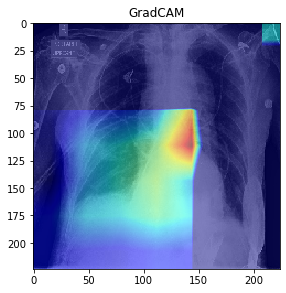

In [33]:
gradcam = compute_saliency(model, guided_model, '../CheXpert-v1.0-small/valid/patient64740/study1/view1_frontal.jpg', 
                           layer_name='conv5_block16_2_conv', 
                           cls=-1, visualize=True, save=False)